In [2]:
import numpy as np
import dsuite
import gym
from softlearning.environments.adapters.gym_adapter import GymAdapter
import os
import imageio
import pickle
import matplotlib.pyplot as plt

from IPython.display import clear_output

/home/justinvyu/anaconda3/envs/vice/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/justinvyu/anaconda3/envs/vice/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/justinvyu/anaconda3/envs/vice/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/justinvyu/anaconda3/envs/vice/lib/pyt

In [3]:
exp_name = 'free_screw_32x32'

In [4]:
cur_dir = os.getcwd()
directory = os.path.join(cur_dir, exp_name)
if not os.path.exists(directory):
    os.makedirs(directory)

Resetting environment...


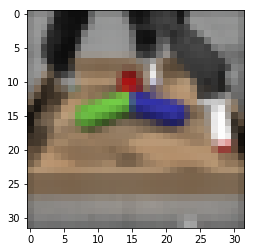

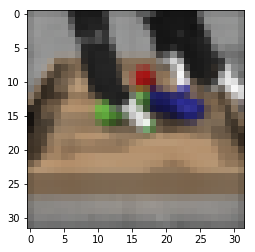

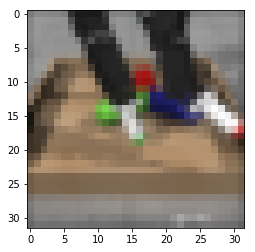

In [6]:
pos_goals = [(0, 0), (0, 0)]
angle_goals = [-90, 90]
images = True
for goal_index, (angle_goal, pos_goal) in enumerate(zip(angle_goals, pos_goals)):
    print(f'\n\n ===== GOAL INDEX: {goal_index}, GOAL: {angle_goal, pos_goal} ===== ')
    num_positives = 0
    NUM_TOTAL_EXAMPLES, ROLLOUT_LENGTH, STEPS_PER_SAMPLE = 250, 25, 4
    ANGLE_THRESHOLD, POSITION_THRESHOLD = 0.15, 0.035
    goal_radians = np.pi / 180. * angle_goal  # convert to radians
    observations = []
    images = True
    image_shape = (32, 32, 3)
#     image_shape = (64, 64, 3)

    x, y = pos_goal
    env_kwargs = {
#         'camera_settings': {
#             'azimuth': 180,
#             'distance': 0.35,
#             'elevation': -55,
#             'lookat': (0, 0, 0.03)
#         },
        'camera_settings': {
            'azimuth': 180,
            'distance': 0.38,
            'elevation': -36,
            'lookat': (0.04, 0.008, 0.026)
        },
        'pixel_wrapper_kwargs': {
            'pixels_only': False,
            'normalize': False,
            'render_kwargs': {
                'width': image_shape[0],
                'height': image_shape[1],
                'camera_id': -1,
            }
        },
#         'goals': ((x, y, 0, 0, 0, goal_radians),),
        'init_qpos_range': (
            (x, y, 0, 0, 0, goal_radians - 0.05),
            (x, y, 0, 0, 0, goal_radians + 0.05)
        ),
        'target_qpos_range': [(x, y, 0, 0, 0, goal_radians)],
        'observation_keys': (
            'pixels',
            'claw_qpos',
            'last_action',
            'goal_index'
        ),
    }

    env = GymAdapter(
        domain='DClaw',
        task='TurnFreeValve3Fixed-v0',
        **env_kwargs
    )
    
    path = os.path.join(directory, f'goal_{goal_index}_{angle_goal}')
    if not os.path.exists(path):
        os.makedirs(path)

    # reset the environment
    while num_positives <= NUM_TOTAL_EXAMPLES:
        observation = env.reset()
        print("Resetting environment...")
        t = 0
        while t < ROLLOUT_LENGTH:
            action = env.action_space.sample()
            for _ in range(STEPS_PER_SAMPLE):
                observation, _, _, _ = env.step(action)
            
            obs = env.get_obs_dict()
            circle_dist = obs['object_to_target_circle_distance']
            pos_dist = obs['object_to_target_position_distance']
            
            if circle_dist < ANGLE_THRESHOLD and pos_dist < POSITION_THRESHOLD:
                # Add observation if meets criteria
                # some hacky shit, find a better way to do this
                observation['goal_index'] = np.array([goal_index])
                observations.append(observation)
                if images:
                    img_obs = observation['pixels']
                    plt.imshow(img_obs)
                    plt.show()
                num_positives += 1
                if num_positives % 50 == 0:
                    clear_output()
            t += 1

    goal_examples = {
        key: np.concatenate([
            obs[key][None] for obs in observations
        ], axis=0)
        for key in observations[0].keys()
    }

    with open(path + '/positives.pkl', 'wb') as file:
        pickle.dump(goal_examples, file)
